In [15]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import numpy as np
import detectron2
import pandas as pd

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg, instantiate
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer

from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [60]:
f = open('team_classification_train/bboxes.json')
data = json.load(f)

In [3]:
for file_name in data:
    img = cv2.imread(f'team_classification_train/frames/{file_name}.jpeg')
    for player in data[file_name]:
        x, y, w, h = data[file_name][player]['box']
        x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
        if x < 0 : x=0
        if y < 0 : y=0
        cv2.imwrite(f'team_classification_train/all_bboxes/bbox_{player}_{file_name}.png', img[y:y+h,x:x+w])

In [5]:
 class SegmentatorNewBaseline:
    def __init__(self, model_name, threshold=0.5):
        print ('Using model', model_name)
        
        # Get model config and weights (download if it doesn't exist):
        self.cfg = model_zoo.get_config(model_name, trained=True)
        # self.cfg = LazyConfig.load("/home/darkalert/builds/detectron2/configs/new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py")
        self.cfg['model']['roi_heads']['box_predictor']['test_score_thresh'] = threshold
        
        # Init:
        self.model = instantiate(self.cfg.model)
        
        # Load a checkpoint:
        DetectionCheckpointer(self.model).load(self.cfg.train.init_checkpoint)
        
        self.model.eval()
        self.model.to('cuda')

    def __call__(self, img, viz=False):
        # Preprocess input image:
        img_tensor = torch.from_numpy(img)
        img_tensor = torch.permute(img_tensor, (2, 0, 1))
        batch = [{"image": img_tensor.to('cuda')}]
        
        # Inference:
        with torch.no_grad():
            outputs = self.model(batch)[0]

        # Vizualize:
        if viz:
            v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(self.cfg['dataloader']['train']['dataset']['names']), scale=3)
            img = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
            plt.imshow(img)
            plt.show()

        return outputs

In [3]:
def show(img, title='', bgr2rgb=True):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if bgr2rgb and img.ndim == 3:
        plt.imshow(img[...,::-1])
    else:
        plt.imshow(img)
    plt.show()

In [161]:
segmentator = SegmentatorNewBaseline('new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py', 0.4)

Using model new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py


In [175]:
features = []
for filename in os.listdir('team_classification_train/all_bboxes'):
    f = os.path.join('team_classification_train/all_bboxes', filename)
    img = cv2.imread(f, 1)
    
    outputs = segmentator(img, viz=False)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for m, l in zip(outputs["instances"].pred_masks,outputs["instances"].pred_classes):
        if l.item() == 0:
            mask += m.cpu().numpy()
            
    x, y = img[mask.astype(bool)].shape

    hists_by_channels = []
    for i in range(3):
        histr = cv2.calcHist([img[mask.astype(bool)].reshape(x, 1, y)],[i],None,[3],[0,256])
        hists_by_channels.append(histr/img.size)
    features.append(np.array(hists_by_channels).ravel())

In [176]:
df = pd.DataFrame(np.array(features))
df.head()

,0,1,2,3,4,5,6,7,8
0,0.093970,0.036539,0.006417,0.101793,0.030034,0.005098,0.091831,0.038531,0.006564
1,0.057800,0.050044,0.011141,0.052141,0.048731,0.018113,0.042390,0.043653,0.032942
2,0.129285,0.030862,0.009913,0.112323,0.044916,0.012821,0.097696,0.052758,0.019605
3,0.109476,0.025673,0.009906,0.091894,0.035292,0.017869,0.075171,0.046122,0.023762
4,0.065479,0.077207,0.020284,0.055265,0.055032,0.052674,0.046767,0.036348,0.079856


In [177]:
# Используем StandardScaler для нормализации данных.
scaler = StandardScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(df), 
    columns=df.columns
)

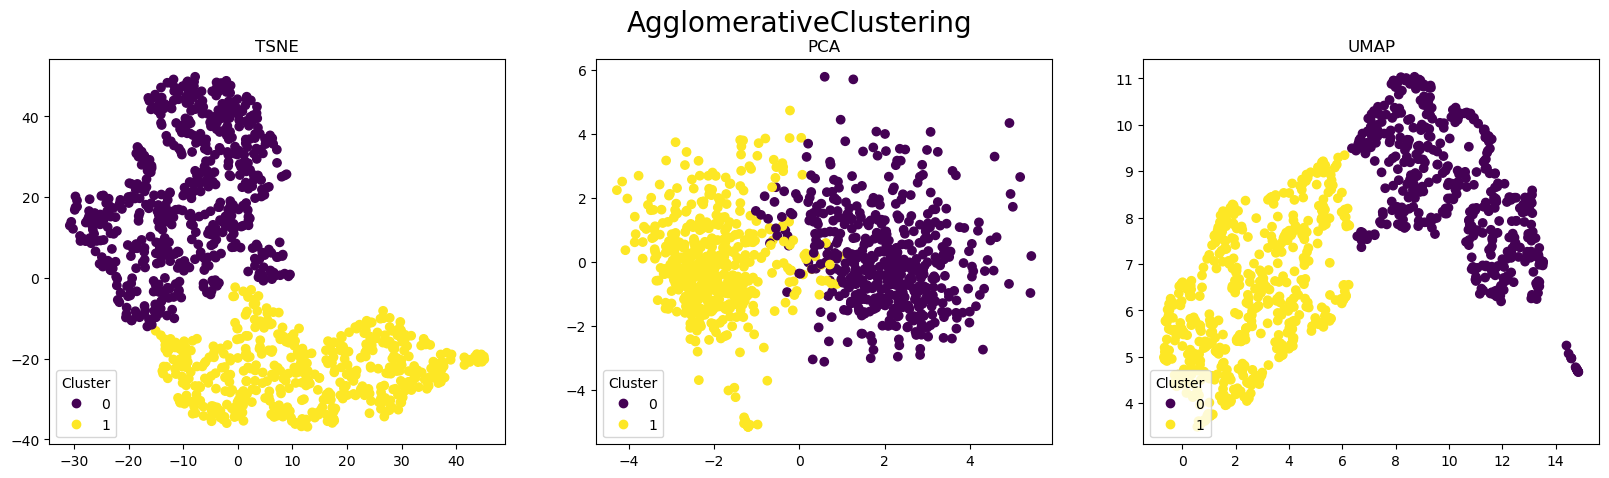

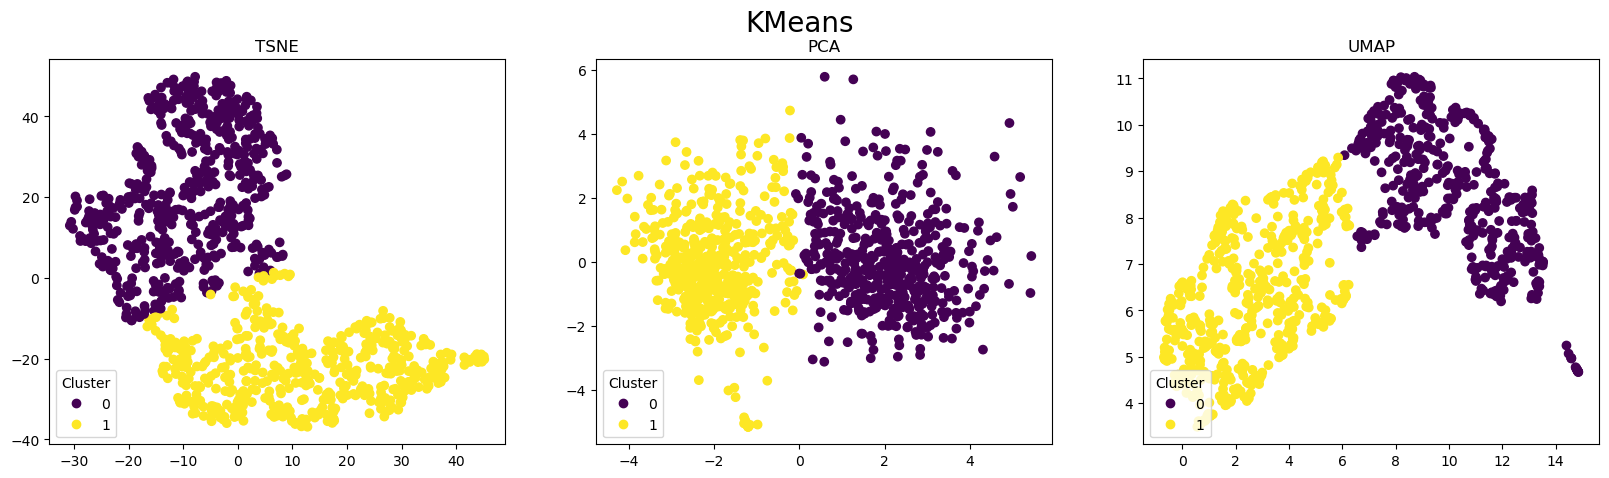

In [178]:
clustering_algorithms = [AgglomerativeClustering, KMeans]
df_labels = pd.DataFrame()

for algorithm in clustering_algorithms:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ind, dim_reducer in enumerate([TSNE, PCA, UMAP]):
        dim_reduced_data = dim_reducer(random_state=42).fit_transform(scaled_data)
        
        model = algorithm(n_clusters=2).fit(dim_reduced_data)
        labels = model.labels_
        df_labels[algorithm.__name__+"_"+dim_reducer.__name__] = model.labels_
        plt.suptitle(algorithm.__name__, fontsize=20)
        scatter = axes[ind].scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)
        axes[ind].set_title(dim_reducer.__name__)
        legend = axes[ind].legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")

In [181]:
model = AgglomerativeClustering(n_clusters=2).fit(dim_reduced_data)
df['team'] = model.labels_
df.head()

,0,1,2,3,4,5,6,7,8,team
0,0.093970,0.036539,0.006417,0.101793,0.030034,0.005098,0.091831,0.038531,0.006564,0
1,0.057800,0.050044,0.011141,0.052141,0.048731,0.018113,0.042390,0.043653,0.032942,1
2,0.129285,0.030862,0.009913,0.112323,0.044916,0.012821,0.097696,0.052758,0.019605,0
3,0.109476,0.025673,0.009906,0.091894,0.035292,0.017869,0.075171,0.046122,0.023762,0
4,0.065479,0.077207,0.020284,0.055265,0.055032,0.052674,0.046767,0.036348,0.079856,1


In [182]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(df.drop(['team'], axis=1), df['team'])

KNeighborsClassifier()

In [183]:
f = open('team_classification_test/gt_bboxes.json')
data = json.load(f)

In [184]:
from sklearn.metrics import accuracy_score

In [185]:
all_acc = []
for file_name in data:
    y_true = []
    y_pred = []
    
    img = cv2.imread(f'team_classification_test/frames/{file_name}.jpeg')
    for player in data[file_name]:
        x, y, w, h = data[file_name][player]['box']
        x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
        if x < 0 : x=0
        if y < 0 : y=0
        img_in_bbox = img[y:y+h,x:x+w]
        
        outputs = segmentator(img_in_bbox, viz=False)
        mask = np.zeros(img_in_bbox.shape[:2], dtype=np.uint8)
        for m, l in zip(outputs["instances"].pred_masks,outputs["instances"].pred_classes):
            if l.item() == 0:
                mask += m.cpu().numpy()

        x, y = img_in_bbox[mask.astype(bool)].shape

        hists_by_channels = []
        for i in range(3):
            histr = cv2.calcHist([img_in_bbox[mask.astype(bool)].reshape(x, 1, y)],[i],None,[3],[0,256])
            hists_by_channels.append(histr/img_in_bbox.size)
        features.append(np.array(hists_by_channels).ravel())
        
        gist2vec = np.array(hists_by_channels).ravel().reshape(1, -1)
        
        y_true.append(data[file_name][player]['team'])
        y_pred.append(int(neigh.predict(gist2vec)))
    
    
    acc = accuracy_score(y_true, y_pred)
    all_acc.append(acc if acc >= 0.5 else 1 - acc)
np.mean(all_acc)

0.8790000000000002